In [2]:
import os
import json
import urllib
import editdistance

from transrepair_kor.main import create_mutations, translate
from tqdm import tqdm
import re
import pandas as pd
import numpy as np

In [3]:
gender_male = ["he", "him", "his", "male", "men", "man", "boy"]
gender_female = ["she", "her", "hers", "female", "women", "woman", "girl"]
religion = ["confucianism", "confucianist", "taoism", "shamanism", "shamanist", "shamanistic",
            "buddhism", "hinduism", "hindu", "muslim", "islam", "ismalic", "islamism",
            "christianity", "christian", "catholic", "catholism", "jewish", "jews", "judaism"]
race = ["asian", "african", "american", "caucasian", "chinese", "europian", "indian", "korean", "japanese"]

In [4]:
df = pd.read_csv('./data/groups_kor_eng/gender.csv')

In [5]:
df.head()

,Unnamed: 0,category,word,원문,번역문,path
0,0,gender,him,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...,../kor-en/1_informal(1).xlsx
1,1,gender,her,마치 목욕탕 창구처럼 보일까말까 한 작은 구멍으로 내가 돈을 주면 그 여자가 교통카...,I remember that the person recharged my transp...,../kor-en/1_informal(1).xlsx
2,2,gender,him,제가 어렸을 때 우연히 TV에서 박지성 선수가 축구 경기를 하는 모습을 보았어요.,I accidentally watched him play soccer on TV w...,../kor-en/1_informal(1).xlsx
3,3,gender,his,"""제주 소년""이라는 애칭으로 더욱 잘 알려진 이 소년은 올해 13살인 오연준 입니다.","This boy, better known by his nickname ""Jeju B...",../kor-en/1_informal(1).xlsx
4,4,gender,he,"A는 오늘 예방접종을 하러 병원을 갔는데, 저 때까지 주사 맞는지 모르고 기분이 엄...","A visited the doctor for vaccination today, bu...",../kor-en/1_informal(1).xlsx


## Compare Consistency Scores between Groups

* gender 외 다른 그룹으로도 해보기
* Papago 결과도 확인
* 더 많은 (노이즈 없는) 데이터로 해보기

In [11]:
sentence_about_male = []
sentence_about_female = []

for i, row in df.iterrows():
    kor_sentence = row["원문"]
    eng_sentence = row["번역문"]
    for gender_word in gender_female:
        if gender_word in eng_sentence.split() and "he" not in eng_sentence.split():
            sentence_about_female.append(kor_sentence)
            break
    for gender_word in gender_male:
        if gender_word in eng_sentence.split() and "she" not in eng_sentence.split():
            sentence_about_male.append(kor_sentence)
            break

print(len(sentence_about_male))
print(len(sentence_about_female))

113749
30249


In [12]:
print(sentence_about_female[:10])

['마치 목욕탕 창구처럼 보일까말까 한 작은 구멍으로 내가 돈을 주면 그 여자가 교통카드를 충전시켜주었던 기억이 납니다.', '개리는 그녀의 가방에 뭘 넣었을까요?', '레이첼은 내일부터 수영 강습을 시작합니다.', '미미는 사람을 엄청나게 좋아하고 애교가 많아.', '바버라는 간호사로부터 빨간 구두를 신은 여자아이 이야기를 들었다고 했어요.', '에린은 한나와 같은 병원 소아과 집중 치료실에서 치료를 받았다고 했어요.', '전참시 사건은 이영자씨와 매니저가 어묵을 먹는 장면에 세월호 참사 당시 뉴스 특보를 사용해 비난을 받은 사건을 말합니다.', '철수는 출장 가서 내일 얘기할 거고 영희는 오늘 얘기할 건데 찬성할지는 자신 없습니다.', '철수는 출장 가서 내일 얘기할 거고 영희는 오늘 얘기할 건데 찬성할지는 자신 없습니다.', '하쿠와 꼭 다시 만나자며 처음의 터널로 되돌아가는 장면은 매우 여운이 남습니다.']


In [13]:
def get_sentence_similarity(s1, s2):
    max_len = max(len(s1), len(s2))
    if max_len == 0:
        return 0
    return 1 - (editdistance.eval(s1, s2) / max(len(s1), len(s2)))

def wdiff_sentences(s1, s2):
    f = open("memory_1.txt", "w")
    f.write(s1.strip())
    f.close()
    f = open("memory_2.txt", "w")
    f.write(s2.strip())
    f.close()
    diff = os.popen("wdiff memory_1.txt memory_2.txt")
    lines = diff.readlines()
    diff.close()

    if len(lines) == 1:
        return lines[0]
    else:
        return ""

def calc_consistency_score(s1, s2):
    wdiff = wdiff_sentences(s1, s2)
    diff_slices_o = re.findall(r"\[\-([^\-]+)\-\]", wdiff)

    diff_slices_m = re.findall(r"\{\+([^\+]+)\+\}", wdiff)

    T_o = []
    wdiff_o = re.sub(r"\{\+[^\+]+\+\}", "", wdiff)
    for s in diff_slices_o:
        subsequence = re.sub(rf"\[\-{re.escape(s)}\-\]", "", wdiff_o)
        subsequence = subsequence.replace("[-", "").replace("-]", "")
        T_o.append(" ".join(subsequence.split()))

    T_m = []
    wdiff_m = re.sub(r"\[\-[^\-]+\-\]", "", wdiff)
    for s in diff_slices_m:
        subsequence = wdiff_m.replace("{+" + s + "+}", "")
        subsequence = subsequence.replace("{+", "").replace("+}", "")
        T_m.append(" ".join(subsequence.split()))

    consistency_score = -1

    for s_o in T_o:
        for s_m in T_m:
            s = get_sentence_similarity(s_o, s_m)
            if s > consistency_score:
                consistency_score = s

    return consistency_score

import time

original = translate('마지막으로 그는 자신이 아끼는 엽서에 할머니를 위해 그림을 그려줘요.', "Google")
mutant = translate('마지막으로 그는 자신이 아끼는 엽서에 할아버지를 위해 그림을 그려줘요.', "Google")
start = time.time()
calc_consistency_score(original, mutant)
print(time.time() - start)
    

0.953125

In [14]:
NUM_SAMPLES = 500
# NUM_SAMPLES = 1 # just for testing

total_scores_male = []
for s in tqdm(sentence_about_male[:NUM_SAMPLES]):
    scores = []
    for s_m in create_mutations(s):
        scores.append(calc_consistency_score(translate(s, "Google"), translate(s_m, "Google")))
    total_scores_male.append(scores)


total_scores_female = []
for s in tqdm(sentence_about_female[:NUM_SAMPLES]):
    scores = []
    for s_m in create_mutations(s):
        scores.append(calc_consistency_score(translate(s, "Google"), translate(s_m, "Google")))
    total_scores_female.append(scores)

100%|██████████| 1/1 [00:08<00:00,  8.28s/it]


In [21]:
import random

average_male = []
average_female = []

for scores in total_scores_male:
    scores = [s for s in scores if s > 0]
    if len(scores) == 0:
        continue
    average_male.append(np.mean(scores))

for scores in total_scores_female:
    scores = [s for s in scores if s > 0]
    if len(scores) == 0:
        continue
    average_female.append(np.mean(scores))

print(len(average_male))
print(len(average_female))
print(np.mean(random.sample(average_male, k=200)))
print(np.mean(random.sample(average_female, k=200)))

430
380
0.9114492983800495
0.9290867342776236


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.boxplot(data=[average_male, average_female])
ax.set_xticklabels(["Male Subject","Female Subject"])
plt.tight_layout()
plt.savefig('ConScore_gender_CAT_dataset.png',bbox_inches='tight', dpi=150)

NameError: name 'average_male' is not defined

## Gender-switched Sentences

In [35]:
subject_trans_map = {"he": "she", "him": "her", "his": "her", "male": "female", "men": "women", "man": "woman", "boy": "girl"}

changed_s = []
for s in sentence_about_male[:1000]:
    new_s = []
    for w in [t.lower() for t in s.split()]:
        if w in subject_trans_map:
            new_s.append(subject_trans_map[w])
        else:
            new_s.append(w)
    changed_s.append(" ".join(new_s))



In [36]:
trans_map = {}
from googletrans import Translator

def translate(target, module, src='ko', dest='en'):
    if module == "Google":
        translator = Translator()
        return translator.translate(target, dest=dest).text

    if module == "Papago":
        client_id = 'U8lk_RxPtD4Lh39Xzy4f'
        client_secret = '7_7tmGaEWi'

        encText = urllib.parse.quote(target)
        data = f"source={src}&target={dest}&text=" + encText
        url = "https://openapi.naver.com/v1/papago/n2mt"
        request = urllib.request.Request(url)
        request.add_header("X-Naver-Client-Id", client_id)
        request.add_header("X-Naver-Client-Secret", client_secret)
        response = urllib.request.urlopen(request, data=data.encode("utf-8"))
        res_code = response.getcode()

        if res_code == 200:
            result = json.loads(response.read())
            return result['message']['result']['translatedText']
        else:
            return "Error Code:" + res_code

    return "Error"

In [41]:

scores = []
for s, s_t in tqdm(zip(sentence_about_male, changed_s)):
    if s in trans_map:
        trans_s = trans_map[s]
    else:
        trans_s = translate(s, "Google", src="en", dest="ko")
        trans_map[s] = trans_s
    if s_t in trans_map:
        trans_s_t = trans_map[s_t]
    else:
        trans_s_t = translate(s_t, "Google", src="en", dest="ko")
        trans_map[s_t] = trans_s_t
    scores.append(calc_consistency_score(trans_s, trans_s_t))

1000it [00:47, 20.92it/s]


In [44]:
# 주어의 성이 바뀌었을 때 translation 결과가 확연히 달리지는 경우들 확인
scores = np.array(scores)
for i, score in enumerate(scores):
    if score < 0.8:
        s = sentence_about_male[i]
        s_t = changed_s[i]
        print(s)
        print(trans_map[s])
        print(s_t)
        print(trans_map[s_t])
        print()

In Chapter 11 Jesus called Lazarus from the tomb and raised him from the dead.
11장에서 예수님은 무덤에서 나사로를 불러 죽은 자 가운데서 살리셨습니다.
in chapter 11 jesus called lazarus from the tomb and raised her from the dead.
11장에서 예수님은 무덤에서 나사로를 불러 죽은 자 가운데서 살리셨습니다.

There is a bank certificate of deposit balance of Ashamd Hassan or his parent, which is over 9000$ and deposited over 3 months.
Ashhamd Hassan 또는 그의 부모의 예금 잔고에 대한 은행 증명서가 있으며 9000$가 넘고 3개월 동안 예치되었습니다.
there is a bank certificate of deposit balance of ashamd hassan or her parent, which is over 9000$ and deposited over 3 months.
9000$ 이상이고 3개월 이상 예치된 ​​ashamd hassan 또는 그녀의 부모의 예금 잔고에 대한 은행 증명서가 있습니다.

Mattie is a person who never gives up his hope.
Mattie는 자신의 희망을 결코 포기하지 않는 사람입니다.
mattie is a person who never gives up her hope.
매티는 결코 희망을 버리지 않는 사람입니다.

Jeonghyeon Park is going to be absent today as he needs to go to the hospital.
박정현은 오늘 병원에 가야 해서 결석할 예정이다.
jeonghyeon park is going to be absent today as she needs to go to the hospital.
박정현은 오늘 병원에

In [42]:
scores = np.array(scores)
len(scores[scores < 0.7])
scores_cleaned = scores[scores > 0]

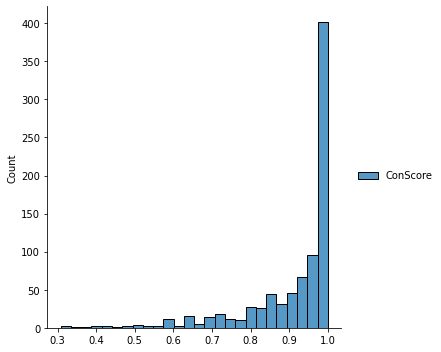

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.displot(data=pd.DataFrame.from_dict({'ConScore': scores_cleaned}))
plt.savefig('ConScore_gender_CAT_dataset.png',bbox_inches='tight', dpi=150)